## Introdução ao problema abordado

Neste trabalho, escolhemos a tarefa de geração de legendas para imagens (Image-to-Text), que consiste em fazer com que um modelo de aprendizado profundo consiga descrever automaticamente o conteúdo de uma imagem com uma frase em linguagem natural. A ideia é que o modelo consiga olhar para uma imagem e gerar uma legenda que seja coerente e faça sentido, considerando os objetos, as ações e o contexto presentes na cena.
Esse problema é interessante porque junta duas áreas diferentes da inteligência artificial, sendo elas a visão computacional e o processamento de linguagem natural. O modelo precisa não só identificar o que aparece na imagem, mas também traduzir isso para uma frase bem escrita e que capture o que está acontecendo. Isso não é trivial, já que a mesma imagem pode ser descrita de várias formas diferentes, e nem sempre é fácil decidir o que merece ser mencionado na legenda e o que pode ser ignorado. Apesar disso, é uma tarefa com muitas aplicações práticas, como melhorar a acessibilidade para pessoas com deficiência visual, organizar automaticamente grandes acervos de imagens, e até mesmo servir de base para sistemas mais complexos que integram visão e linguagem.

O conjunto de dados usado para o projeto foi o COCO 2014, que é um dos mais conhecidos para tarefas de geração de legendas. Ele tem milhares de imagens do cotidiano, com várias categorias de objetos e cenas naturais, como pessoas, animais, veículos, ambientes internos e externos. Cada imagem vem acompanhada de cinco legendas diferentes, todas escritas por pessoas, o que ajuda o modelo a aprender diferentes formas de descrever a mesma cena.

## Requerimentos

In [ ]:
### Se der problema de memoria (Cuda Out Of Memory) em qualquer momento do codigo: reiniciar Kernel e executar tudo novamente por causa do cache da gpu

%env TOKENIZERS_PARALLELISM=false
%pip install torch torchvision --quiet
%pip install transformers --quiet
%pip install pycocotools --quiet
%pip install ipywidgets matplotlib --quiet
%pip install timm --quiet
%pip install peft --quiet
%pip install git+https://github.com/salaniz/pycocoevalcap.git --quiet # PARA MÈTRICA 'cider'

env: TOKENIZERS_PARALLELISM=false
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.5 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packag

## Bibliotecas usadas

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import torch
from torchvision import models, datasets, transforms
import pycocotools
import transformers
import os
import matplotlib.pyplot as plt
from torch.utils.data import Subset, DataLoader
import random
random.seed(42)
from torchvision.transforms.functional import to_pil_image
import timm
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from transformers import (
    VisionEncoderDecoderModel,
    AutoFeatureExtractor,
    AutoTokenizer
)
from torch.amp import autocast, GradScaler
import gc
from pycocoevalcap.cider.cider import Cider
import time


2025-07-01 19:18:21.418918: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751397501.637421      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751397501.701492      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Parâmetros

In [ ]:
### CONSTANTES
CAPTION_MAX_LENGTH = 32
BATCH_SIZE         = 16
NUM_EPOCHS         = 10
LEARNING_RATE      = 5e-5
WEIGHT_DECAY       = 1e-2
TRAIN_SAMPLE_SIZE = 82783
VAL_SAMPLE_SIZE = 2000
TEST_SAMPLE_SIZE = 2000
TREINO = True ### True se for treinar modelos, CC. apenas avaliar já treinados que estão no input do kaggle

MODELO_VIT_BART = True

ENCODER = None
DECODER = None
if MODELO_VIT_BART:
    ENCODER = 'google/vit-large-patch16-224-in21k'
    DECODER = 'facebook/bart-base'
else:
    ENCODER = 'microsoft/swin-base-patch4-window7-224'
    DECODER = 'facebook/bart-base'



## Dataset utilizado

Para o treinamento, usamos o subconjunto train2014, que tem mais de 80 mil imagens. Antes de passar as imagens para o modelo, fizemos um pré-processamento básico: redimensionamos todas para um tamanho fixo e aplicamos algumas técnicas de data augmentation, como rotação e mudança de brilho, para aumentar a variedade dos exemplos e ajudar o modelo a generalizar melhor. Também tratamos as legendas, transformando o texto em tokens e construindo um vocabulário limitado às palavras mais frequentes, o que reduz o risco de overfitting e torna o treinamento mais eficiente. Esse conjunto de dados é ideal para essa tarefa porque tem bastante variedade tanto nas imagens quanto nas descrições, o que ajuda o modelo a aprender padrões mais gerais em vez de memorizar exemplos específicos.


## Criação dos datasets, criação de amostras e teste inicial

loading annotations into memory...
Done (t=1.32s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
Número total de exemplos de treino:  82783
Número total de exemplos de teste:  5000
Tamanho da amostra de treino:  82783
Tamanho da amostra de teste:  2000
Dimensões da imagem: torch.Size([3, 640, 480])
Legenda (lista de captions):
['A bowl of oranges is placed on a table.', 'A blue bowl filled with oranges on a wood table.', 'a bowl on a table full of oranges', 'A blue bowl of oranges is sitting on a wooden table.', 'oranges in a blue bowl on a wooden table']


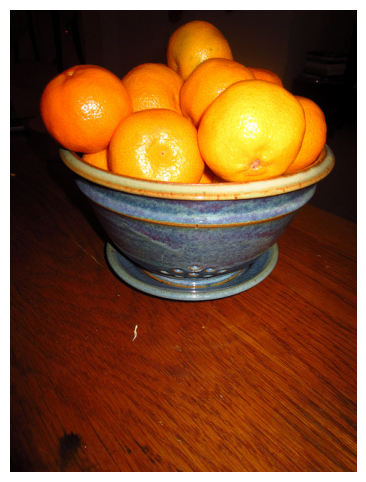

In [ ]:
### criação dos datasets de treino e teste
dados_treino = datasets.CocoCaptions(
    root='/kaggle/input/coco-image-caption/train2014/train2014',
    annFile='/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/captions_train2014.json',
    transform=transforms.PILToTensor()
)
dados_teste = datasets.CocoCaptions(
    root='/kaggle/input/coco-image-caption/val2017/val2017',
    annFile='/kaggle/input/coco-image-caption/annotations_trainval2017/annotations/captions_val2017.json',
    transform=transforms.PILToTensor()
)

### pegando amostras aleatorias
indices_treino = random.sample(range(len(dados_treino)), TRAIN_SAMPLE_SIZE)
indices_teste  = random.sample(range(len(dados_teste)), TEST_SAMPLE_SIZE)
indices_val  = random.sample(range(len(dados_teste)), VAL_SAMPLE_SIZE)

amostra_treino = Subset(dados_treino, indices_treino)
amostra_teste = Subset(dados_teste, indices_teste)
amostra_val  = Subset(dados_teste, indices_val)

print('Número total de exemplos de treino: ',len(dados_treino))
print('Número total de exemplos de teste: ',len(dados_teste))
print('Tamanho da amostra de treino: ',len(amostra_treino))
print('Tamanho da amostra de teste: ',len(amostra_val))

### teste
img, target = amostra_treino[3]
pil_img = to_pil_image(img)

print('Dimensões da imagem:', img.size())
print('Legenda (lista de captions):')
print(target)

plt.figure(figsize=(6, 6))
plt.imshow(pil_img)
plt.axis('off')
plt.show()

## Arquitetura do Modelo

A arquitetura do modelo é baseada na abordagem Vision Encoder-Decoder (VED), que combina dois modelos pré-treinados: um modelo de visão computacional, utilizado como encoder (CNN ou um Vision Transformer), e um modelo de linguagem natural, utilizado como decoder. Esses dois módulos são conectados por meio de camadas de cross-attention.

A principal função dessa arquitetura é utilizar os embeddings extraídos pelo encoder como keys e values para a cross-attention, enquanto os embeddings gerados pelo decoder são utilizados como querys. Com isso, é possível treinar o modelo a partir de pares imagem-descrição: a imagem é convertida em um embedding pelo encoder, enquanto a descrição é convertida em um embedding pelo decoder.

A saída da camada de atenção do decoder é uma matriz (dimensão: tamanho da sequência × tamanho do vocabulário do modelo de LLM), a qual, após a aplicação da função softmax, representa a distribuição de probabilidade das palavras em cada posição da sequência. Na nossa tarefa,, a matriz de atenção é modulada pelas regiões da imagem, permitindo que o modelo associe palavras a regiões da imagem. Assim, o modelo aprende a prever o próximo token com base na combinação contextual entre os embeddings da imagem e os estados anteriores da sequência textual, capturando correlações entre objetos visuais e descrições.

Além disso o modelo é configurado para reduzir repetição de tokens e penalizar sequências longas.

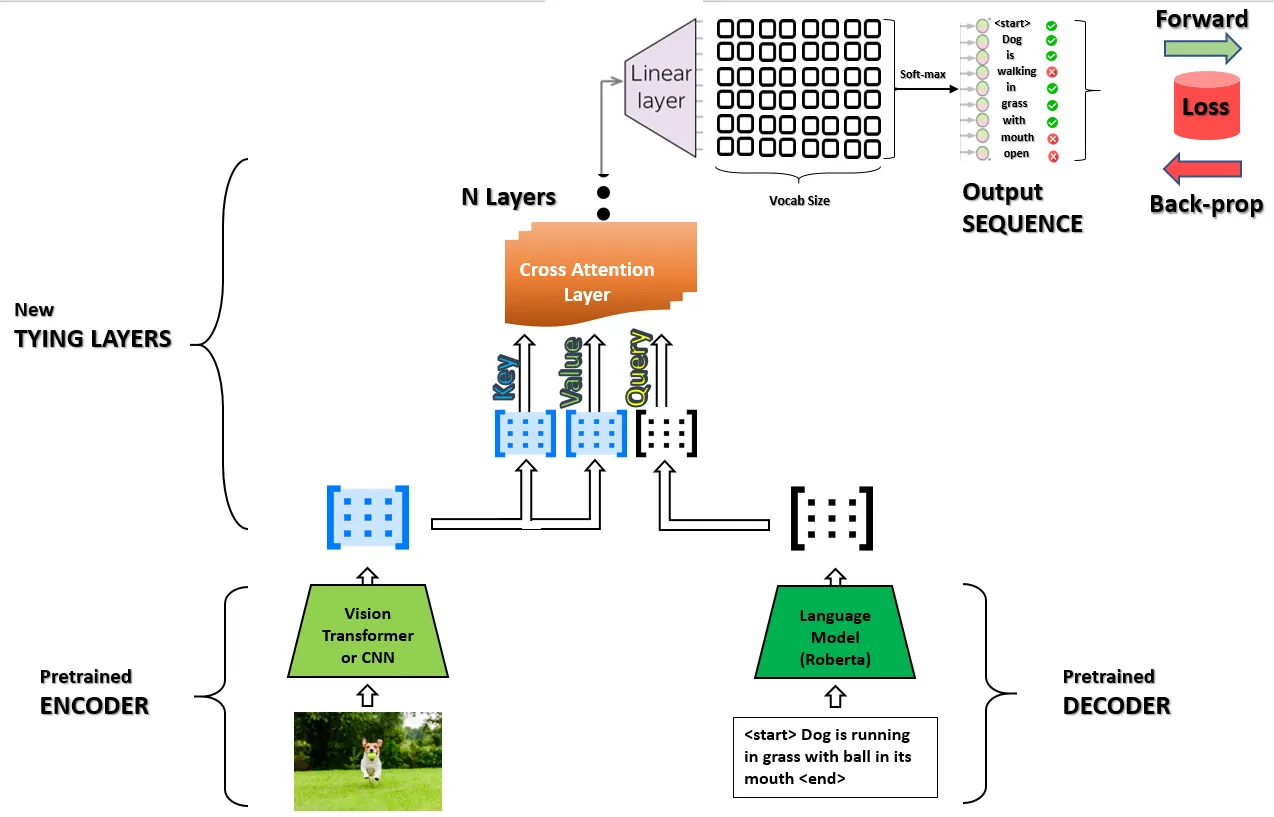

## Definição do modelo, congelamento das camadas do encoder, definição do extrator de features e tokenizer

In [ ]:
### verifica se tem gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

### modelo com encoder e decoder pretreinados (sem finetuning algum e sem camadas de cross-attention)
### porem o VisionEncoderDecoderModel cria camadas de cross-attention com pesos aleatórios ligando o encoder e o decoder
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(

    ENCODER,
    DECODER,
    device_map='auto'

).to(device)

### congela pesos do encoder para treinar apenas o decoder e as camadas de cross-attention intermediarias
for param in model.encoder.parameters():
    param.requires_grad = False


### feature extractor para pegar a ultima camada oculda da CNN e tokenizer do LLM para transformar as legendas em tokens
feature_extractor = AutoFeatureExtractor.from_pretrained(
    ENCODER
)

### transformar a legenda em um array de tokens do vocabulário do modelo
tokenizer = AutoTokenizer.from_pretrained(DECODER)


model.config.use_cache = False

config                         = model.config
config.decoder_start_token_id  = tokenizer.bos_token_id
config.eos_token_id            = tokenizer.eos_token_id
config.pad_token_id            = tokenizer.pad_token_id
config.vocab_size              = model.decoder.config.vocab_size
config.loss_type               = "ForCausalLMLoss"
config.early_stopping = True
config.no_repeat_ngram_size = 3
config.length_penalty = 2.0
config.num_beams = 4


### teste tokenizer

print('BOS token: ',tokenizer.bos_token_id)
print('EOS token: ',tokenizer.eos_token_id)
print('PAD token: ',tokenizer.pad_token_id)

tokenizer_test = tokenizer

text = "A dog playing in the park."

print("Texto original:", text)


# tokeniza com padding (até comprimento 10) e special tokens
encoded2 = tokenizer_test(
    text,
    padding='max_length',
    truncation=True,
    max_length=10,
    add_special_tokens=True,
    return_attention_mask=True
)
print("--- Com add_special_tokens + padding até", 10, "---")
print("Tokens:", tokenizer_test.convert_ids_to_tokens(encoded2['input_ids']))
print("Token IDs:", encoded2['input_ids'])
print("Attention mask:", encoded2['attention_mask'])

## Função de preparação dos dados para o batch (tokenização da legenda e extração de features da imagem)

In [ ]:
### função de preparação dos dados
def collate_fn(batch):
    ### batch: lista de tuplas (PIL image, [legendas])
    images, all_captions = zip(*batch)

    ### seleciona as duas primeiras legendas e duplica cada imagem
    images_expanded = []
    captions = []
    for img, caps in zip(images, all_captions):
        ### caps é lista de até 5 strings (legendas); pega as duas primeiras
        for c in caps[:2]:
            images_expanded.append(img)
            captions.append(c)

    ### adiciona o token <|endoftext|> no final de todas as captions
    eos_token = tokenizer.eos_token or tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id)
    captions = [c.strip() + eos_token for c in captions]


    ### extrai pixel_values de todas as imagens expandidas
    encoding = feature_extractor(images_expanded, return_tensors='pt')
    pixel_values = encoding.pixel_values  # [2*B, C, H, W]

    ### tokeniza todas as legendas (2 por imagem)
    tokens = tokenizer(
        captions,
        padding='max_length',
        truncation=True,
        max_length=CAPTION_MAX_LENGTH,
        return_tensors='pt',
        add_special_tokens=True
    )
    labels = tokens.input_ids  # [2*B, T]

    ### marca padding para o loss ignorar
    labels = labels.masked_fill(labels == tokenizer.pad_token_id, -100)

    return {
        'pixel_values': pixel_values,
        'labels'      : labels
    }

## Separando Batchs de treino e validação/teste

In [ ]:
### dividindo os dados em batchs
if TREINO:
    train_loader = DataLoader(
        amostra_treino,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
        collate_fn=collate_fn
    )
    val_loader = DataLoader(
        amostra_val,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )

## Treino

Para o treino do modelo, as camadas do encoder são congeladas para treinar apenas o decoder e as camadas de cross-attention intermediárias; o cache é desativado para que os estados anteriores da LLM não atrapalhem, e são extraídas as features da última camada oculta do encoder.
Os dados são divididos em batches de 16 e são agrupados de forma que cada imagem tenha duas legendas; para isso, as imagens são duplicadas, é adicionado o token de final de texto, e as legendas são tokenizadas de acordo com o vocabulário do modelo decoder, sendo que os tokens de padding são ignorados para não causarem problemas na função de loss.
É usado o otimizador AdamW e a função Causal Language Modeling (CLM) de loss, que calcula a diferença entre cada token gerado pela sequência da rede e o embedding da legenda gerado pela LLM; dessa forma, as camadas do decoder e as camadas intermediárias do cross-attention são treinadas com pesos mais precisos

In [ ]:
### otimizador, orquestrador e scaler (permite o treino ter precisão mista (16bits-32bits) dinâmicamente)
if TREINO:

    t1 = time.time()

    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.9)
    scaler = GradScaler('cuda')

    print('Iniciando Treino')

    for epoch in range(NUM_EPOCHS):

        ### treino
        model.train()
        total_loss = 0.0
        for batch in train_loader:
            pixel_values = batch['pixel_values'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            with autocast('cuda'):  # forward em fp16
                outputs = model(pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)

        ### eval
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                pixel_values = batch['pixel_values'].to(device)
                labels = batch['labels'].to(device)

                with autocast('cuda'):  ### forward em fp16
                    outputs = model(pixel_values=pixel_values, labels=labels)
                total_val_loss += outputs.loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        print(
            f'Época {epoch+1}/{NUM_EPOCHS} - '
            f'train_loss: {avg_train_loss:.4f} - '
            f'val_loss:   {avg_val_loss:.4f}'
        )
        scheduler.step()

    model.config.use_cache = True

    t2 = time.time()

    print("Tempo de treino: ", (t2-t1))


In [ ]:
### geração de exemplos

indices = [0, 1, 2, 3]

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for ax, idx in zip(axs.flatten(), indices):

    img_tensor, _ = dados_teste[idx]
    pil_img = to_pil_image(img_tensor)

    pixel = feature_extractor(pil_img, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(
        pixel,
        max_length=CAPTION_MAX_LENGTH,
        num_beams=4,
        early_stopping=True,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        decoder_start_token_id=tokenizer.bos_token_id,
        use_cache=True
    )
    caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    ax.imshow(pil_img)
    ax.set_title(caption, pad=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Salvando modelos treinados

In [ ]:
### lembrem-se de salvar os modelo em um dataset chamado 'modelos'
torch.save(model.state_dict(), '/kaggle/working/VIT_BART_model.pth')

## Avaliação dos modelos

In [ ]:
### tenta limpar o cache da GPU
model = None

gc.collect()

torch.cuda.empty_cache()

In [ ]:
cider_scorer = Cider()

### VIT + BART

Esse modelo foi especificamente testado com 10 épocas, como mostrado na imagem abaixo

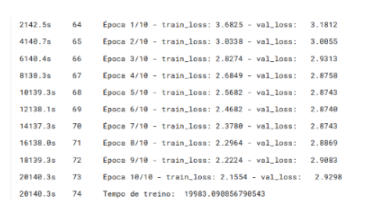

É possível ver para essa combinação em específico que apesar do train_loss diminuir durante o tempo o val_loss apesar de começar de maneira decrescente, na época 6 tem um aumento da loss do valor e o valor da loss continua aumentando, assim ocorrendo overfitting do modelo.
Como mostrado nos resultados 2 blocos abaixo das legendas criadas para as imagens o modelo consegue entender coisas mais gerais como “living” “wood” “walls” para a primeira mensagem, que qual consegue descrever que é uma sala de estar com paredes e o “wood” provavelmente sendo do chão de madeira, ou o urso marrom que realmente está sentado na grama, isso mostra o modelo consegue identificar perfeitamente cores de objetos assim do contexto mais geral do local da imagem, a melhor descrição do modelo se encontra na imagem do quarto de dormir que o modelo consegue identificar ser um quarto de dormir além dos livros e da prateleira, além disso é possível ver que o modelo gera legendas que se repetem muito, sempre repetindo palavras e o “and” para a descrição.
O resultado da métrica CIDEr 0.27 sendo uma média do resultado das legendas geradas não é uma média muito boa comparado com modelos SOA, porém com nosso pouco poder computacional usando as GPUs da conta “free” do kaggle quantidade de dados e poucas épocas é um bom resultado.


#### Carregando modelo treinado

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model_vitbart = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(

    'google/vit-large-patch16-224-in21k',
    'facebook/bart-base',
    device_map='auto'

).to(device)

feature_extractor = AutoFeatureExtractor.from_pretrained(
    'google/vit-large-patch16-224-in21k'
)

tokenizer = AutoTokenizer.from_pretrained('facebook/bart-base')

model_vitbart.decoder.resize_token_embeddings(len(tokenizer))

config                         = model_vitbart.config
config.decoder_start_token_id  = tokenizer.bos_token_id
config.eos_token_id            = tokenizer.eos_token_id
config.pad_token_id            = tokenizer.pad_token_id
config.vocab_size              = model_vitbart.decoder.config.vocab_size
config.loss_type               = "ForCausalLMLoss"
config.early_stopping = True
config.no_repeat_ngram_size = 3
config.length_penalty = 2.0
config.num_beams = 4

model_vitbart.load_state_dict(torch.load('/kaggle/input/modelo_vit_bart/pytorch/default/1/VIT_BART_model.pth'))

model_vitbart.eval()

print('Carregado')

cuda


config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Some weights of BartForCausalLM were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['lm_head.weight', 'model.decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Carregado


#### Mostrando exemplos

/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1667: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


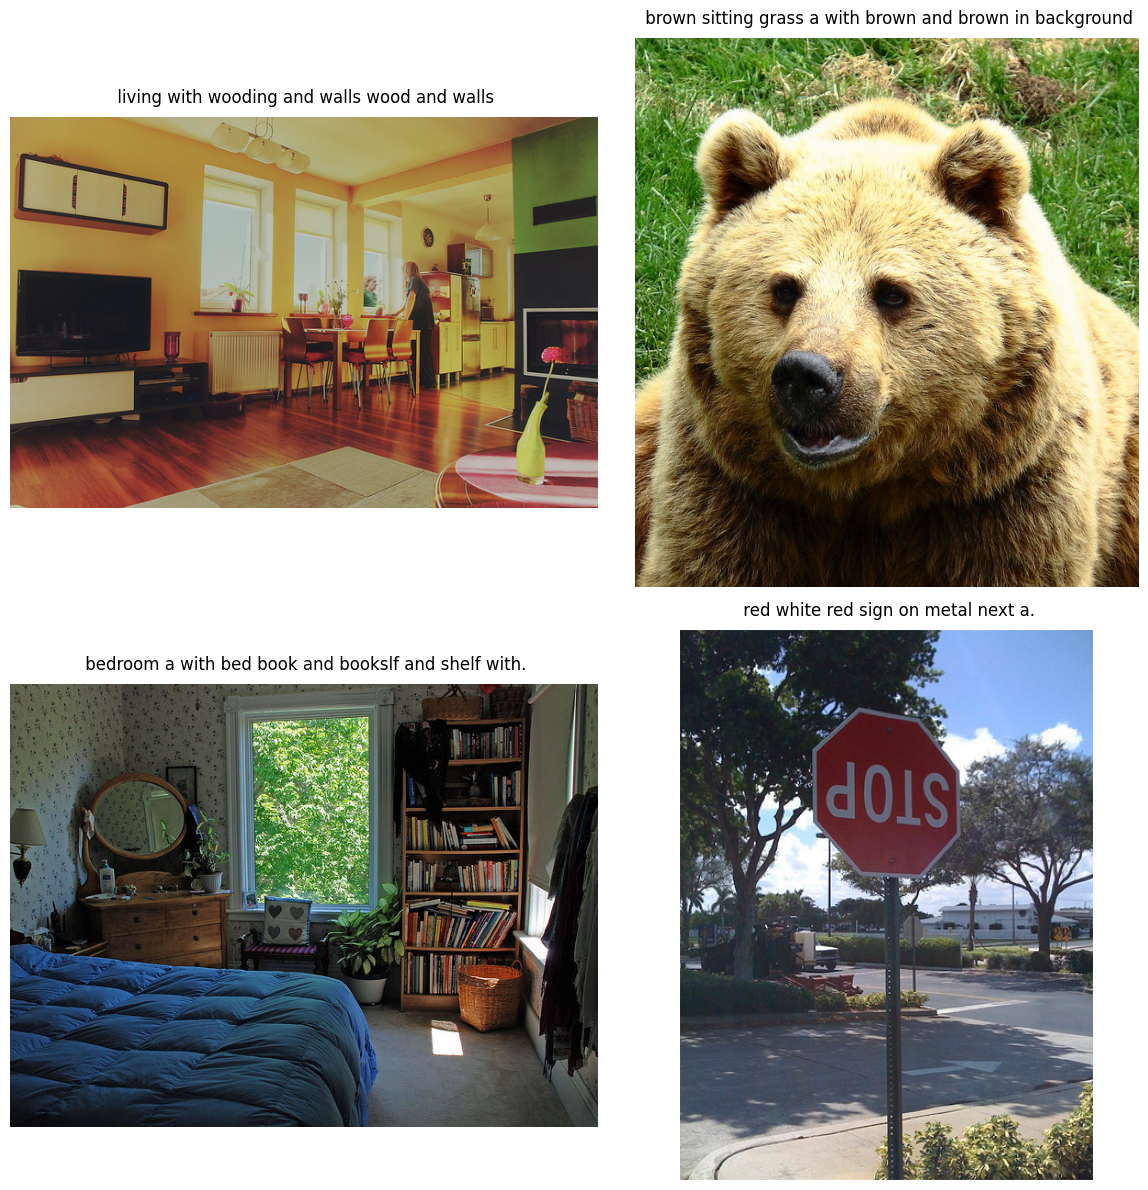

In [ ]:
### geração de exemplos

indices = [0, 1, 2, 3]

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for ax, idx in zip(axs.flatten(), indices):

    img_tensor, _ = dados_teste[idx]
    pil_img = to_pil_image(img_tensor)

    pixel = feature_extractor(pil_img, return_tensors='pt').pixel_values.to(device)
    generated_ids = model_vitbart.generate(
        pixel,
        max_length=CAPTION_MAX_LENGTH,
        num_beams=4,
        early_stopping=True,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        decoder_start_token_id=tokenizer.bos_token_id,
        use_cache=True
    )
    caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    ax.imshow(pil_img)
    ax.set_title(caption, pad=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

#### Calcula score CIDEr

In [ ]:
preds = {}
refs  = {}

for idx in range(len(amostra_teste)):
    img, cap_list = amostra_teste[idx]
    pixel = feature_extractor(img, return_tensors='pt').pixel_values.to(model_vitbart.device)

    out_ids = model_vitbart.generate(
        pixel,
        max_length=CAPTION_MAX_LENGTH,
        num_beams=4,
        pad_token_id=config.pad_token_id,
        eos_token_id=config.eos_token_id,
        decoder_start_token_id=config.decoder_start_token_id,
        use_cache=True
    )
    pred = tokenizer.decode(out_ids[0], skip_special_tokens=True)

    img_id = str(idx)
    preds[img_id] = [pred]
    refs[img_id] = cap_list


score, scores = cider_scorer.compute_score(refs, preds)
print("CIDEr médio:", score)

CIDEr médio: 0.27215642718080135


In [ ]:
### tenta limpar o cache da GPU
model_vitgpt = None

gc.collect()

torch.cuda.empty_cache()

### SWIN + BART

Esse modelo foi especificamente testado com 20 épocas, como mostrado na imagem abaixo:
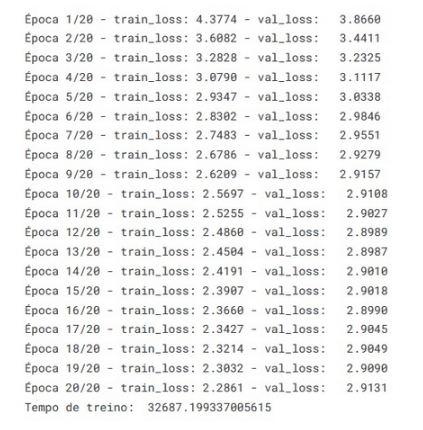

é possível ver para essa combinação que tanto o train_loss quanto o val_loss diminuem ao longo das épocas, com a validação oscilando um pouco a partir da época 10, mas de forma geral mantendo uma tendência de estabilização, sem apresentar picos que indiquem overfitting claro. o modelo segue aprendendo ao longo do tempo, com uma queda constante no erro de treino.
como mostrado nos 2 blocos abaixo das legendas geradas, o modelo consegue identificar algumas estruturas mais amplas nas imagens, como “room”, “table”, “bed”, “book” e “bear”, conseguindo capturar o cenário geral. por exemplo, na primeira imagem, o modelo cita “room a room a and room a couch a and table”, o que mostra que ele entendeu o ambiente como sendo uma sala com móveis, mesmo com repetição de termos e erros gramaticais. na imagem do urso, ele consegue descrever “large bear a in middle grass area a”, indicando que ele reconhece o animal e o local, apesar da frase não estar natural. na imagem do quarto, o modelo cita “bed a with book and book next ahe bed”, o que mostra que ele consegue localizar a cama e os livros próximos, embora com erro de digitação e repetição. já na imagem da placa de trânsito, ele gera “stop and signs a sign a and street.”, demonstrando que reconheceu o objeto principal e o contexto urbano, mas também com redundância de palavras.

o resultado da métrica CIDEr foi de 0.269, sendo uma média do resultado das legendas geradas. não é uma média muito boa comparado com modelos SOA, porém com nosso pouco poder computacional usando as GPUs da conta "free" do kaggle, quantidade de dados e poucas épocas, é um bom resultado.


#### Carregando modelo treinado

In [ ]:
model_swinbart = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(

    'microsoft/swin-base-patch4-window7-224',
    'facebook/bart-base',
    device_map='auto'

).to(device)


config                         = model_swinbart.config
config.decoder_start_token_id  = tokenizer.bos_token_id
config.eos_token_id            = tokenizer.eos_token_id
config.pad_token_id            = tokenizer.pad_token_id
config.vocab_size              = model_swinbart.decoder.config.vocab_size
config.loss_type               = "ForCausalLMLoss"
config.early_stopping = True
config.no_repeat_ngram_size = 3
config.length_penalty = 2.0
config.num_beams = 4


model_swinbart.load_state_dict(torch.load('/kaggle/input/modelo_swin/pytorch/default/1/SWIN_BART_model.pth'))

model_swinbart.eval()

print('Carregado')

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/352M [00:00<?, ?B/s]

Some weights of BartForCausalLM were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['lm_head.weight', 'model.decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Carregado


#### Mostrando exemplos

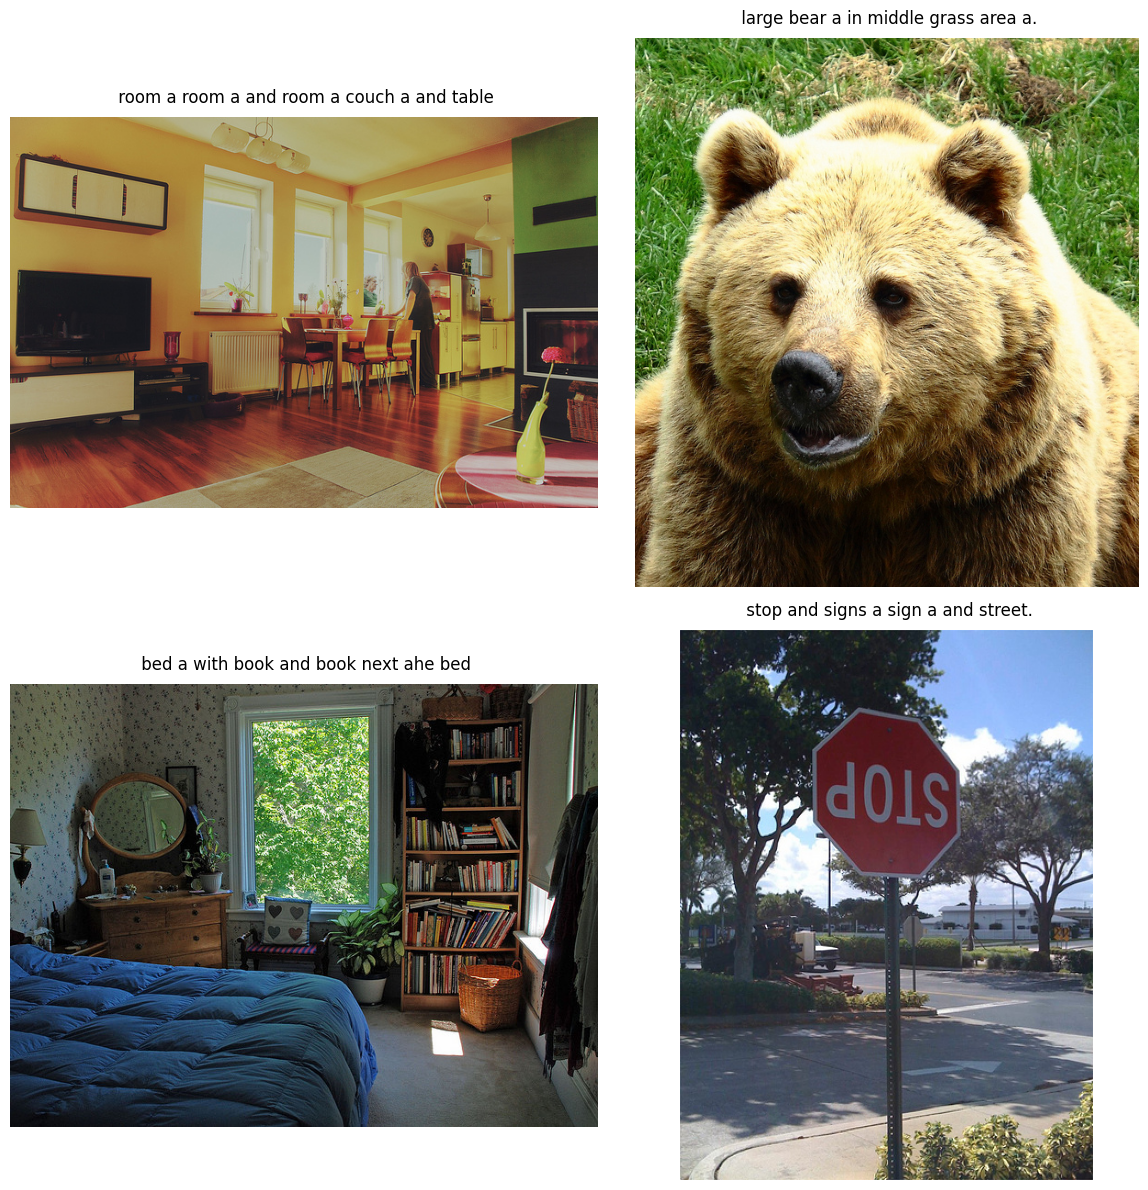

In [ ]:
### geração de exemplos

indices = [0, 1, 2, 3]

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

for ax, idx in zip(axs.flatten(), indices):

    img_tensor, _ = dados_teste[idx]
    pil_img = to_pil_image(img_tensor)

    pixel = feature_extractor(pil_img, return_tensors='pt').pixel_values.to(device)
    generated_ids = model_swinbart.generate(
        pixel,
        max_length=CAPTION_MAX_LENGTH,
        num_beams=4,
        early_stopping=True,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        decoder_start_token_id=tokenizer.bos_token_id,
        use_cache=True
    )
    caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    ax.imshow(pil_img)
    ax.set_title(caption, pad=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

#### Calcula score CIDEr

In [ ]:
preds = {}
refs  = {}

for idx in range(len(amostra_teste)):
    img, cap_list = amostra_teste[idx]
    pixel = feature_extractor(img, return_tensors='pt').pixel_values.to(model_swinbart.device)

    out_ids = model_swinbart.generate(
        pixel,
        max_length=CAPTION_MAX_LENGTH,
        num_beams=4,
        pad_token_id=config.pad_token_id,
        eos_token_id=config.eos_token_id,
        decoder_start_token_id=config.decoder_start_token_id,
        use_cache=True
    )
    pred = tokenizer.decode(out_ids[0], skip_special_tokens=True)

    img_id = str(idx)
    preds[img_id] = [pred]
    refs[img_id] = cap_list


score, scores = cider_scorer.compute_score(refs, preds)
print("CIDEr médio:", score)

CIDEr médio: 0.26909504104407395


In [ ]:
### tenta limpar o cache da GPU
mode_swinbart = None

gc.collect()

torch.cuda.empty_cache()

In [ ]:
### tenta limpar o cache da GPU

train_loader = None
val_loader = None
optimizer = None
tokenizer = None
feature_extractor = None
scheduler = None
pixel_values = None
labels = None
amostra_treino = None
amostra_val = None
amostra_teste = None


gc.collect()

torch.cuda.empty_cache()

## Conclusão

Os resultados mostram que os modelos conseguiram captar bem os aspectos mais importantes das imagens e gerar legendas que fazem sentido na maior parte dos casos. Quando as imagens são mais simples, com objetos isolados ou cenas menos complexas, as legendas ficam bastante coerentes, com descrições claras e até detalhadas, mencionando cores e elementos do ambiente. Já em imagens com mais objetos ou cenários mais complexos, o modelo ainda acerta a identificar os principais elementos, mas a fluidez e a estrutura das frases acabam ficando prejudicadas. Em alguns casos, aparecem repetições de palavras ou frases truncadas, o que indica que ele ainda apresenta dificuldade em montar textos mais elaborados quando precisa lidar com muita informação visual.

Isso mostra que a integração entre o encoder visual e o decoder de linguagem está funcionando na direção certa, pois o modelo reconhece bem o que está na imagem, mas na hora de transformar isso em uma legenda natural ainda apresenta falhas. Apesar disso, mesmo quando as legendas não são perfeitas, elas conseguem transmitir o que há de mais importante na imagem.
A avaliação com a métrica CIDEr confirmou essa impressão, mostrando que as legendas geradas tem uma boa aderência às descrições humanas do conjunto
de dados. Além disso, visualmente fica claro o que o modelo “vê” em cada imagem, o que ajuda a entender melhor seu funcionamento.

Quando analisamos com mais atenção, encontramos problemas claros na fluência e na coerência das legendas. Por exemplo, algumas frases apresentam palavras repetidas, como “brown and brown” ou “a a”, outras trazem tokens truncados, como “booksfl”, e algumas frases ficam “desordenadas”, sem formar sentenças gramaticais completas. Isso mostra que o fine-tuning parcial que foi feito ainda não foi suficiente para ensinar o decoder a construir frases naturais.

Também percebemos que a estratégia de geração que usamos, beam search com num_beams=4 e early_stopping ativado, tende a reforçar esses padrões repetitivos, o que acaba reduzindo a diversidade e a fluidez das legendas.

Em resumo, nossos modelos consegue identificar conceitos visuais básicos, como animais, cores e objetos, mas ainda encontra  dificuldades na hora de criar sentenças coerentes e naturais, especialmente quando a cena é mais complexa. Para avançar, poderíamos aumentar a variedade e a quantidade de exemplos usados no fine-tuning, ajustar os parâmetros de geração, e talvez pensar em algum tipo de pós-processamento para corrigir gramática e melhorar a fluidez do texto.

Mesmo com esses desafios, a arquitetura que usamos se mostrou adequada para a tarefa, entregando um desempenho consistente dentro das condições que adotamos para o treinamento. Os resultados apresentados mostram que o modelo tem potencial para entender e descrever imagens, mas ainda há espaço para melhorias importantes a serem feitas na geração textual.


## Discussão Geral

Durante o desenvolvimento deste projeto, tivemos a oportunidade de explorar uma tarefa complexa que envolve tanto visão computacional quanto geração de linguagem natural. Implementar um sistema de geração de legendas nos permitiu entender, na prática, como diferentes componentes de um modelo de aprendizado profundo interagem e quais os principais desafios de integrar módulos de naturezas distintas, como um encoder visual e um decoder textual.

Um dos maiores desafios foi lidar com a parte textual da geração. Apesar de o modelo conseguir capturar os principais elementos visuais das imagens, transformar essas informações em descrições gramaticalmente corretas e coerentes exigiu mais do que simplesmente treinar o decoder com um conjunto reduzido de dados. A qualidade das legendas geradas mostrou-se muito sensível à forma como o fine-tuning foi conduzido, ao tamanho da amostragem usada no treinamento e aos hiperparâmetros de geração adotados.

Outro ponto importante foi a limitação de recursos computacionais. Por se tratar de modelos grandes, como o VIT e BART , tivemos que fazer ajustes na implementação para que o treinamento fosse viável. Isso incluiu o congelamento do encoder, uso de batches menores, redução do número de épocas e, em alguns momentos, a limpeza manual do cache da GPU para evitar erros de memória. Essas escolhas influenciaram diretamente na profundidade do fine-tuning possível e, consequentemente, na qualidade final das legendas geradas.

Além disso, enfrentamos dificuldades técnicas relacionadas ao tokenizador, à preparação dos dados e à padronização dos inputs. A necessidade de duplicar imagens, ajustar as legendas manualmente com tokens especiais e configurar corretamente a função de perda e a atenção cruzada trouxe aprendizados valiosos sobre o funcionamento interno de modelos encoder-decoder.

Do ponto de vista do aprendizado, este projeto foi bastante enriquecedor. Conseguimos consolidar o entendimento de conceitos como embeddings visuais e textuais, atenção cruzada, tokenização, geração autoregressiva e métricas de avaliação como o CIDEr. Também ganhamos experiência prática com bibliotecas modernas como transformers, timm, e o uso de modelos pré-treinados, algo essencial no desenvolvimento de soluções mais robustas e eficientes.

No geral, o projeto demonstrou o potencial da arquitetura adotada para a tarefa de geração de legendas, mesmo com um fine-tuning parcial. Os resultados revelaram tanto os acertos do modelo quanto suas limitações, oferecendo insights claros sobre quais ajustes futuros podem levar a melhorias significativas.
